In [1]:
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

from scipy import integrate, optimize
from scipy.stats import norm
from scipy.stats import uniform
from astroML.plotting import hist
from astroML.plotting.mcmc import convert_to_stdev
from astroML.plotting import setup_text_plots
#setup_text_plots(fontsize=8, usetex=True)
from astroML.plotting.mcmc import convert_to_stdev
import warnings; warnings.simplefilter('ignore')
import corner
import emcee
import time

C:\Users\Admin\anaconda3\lib\site-packages\astroML\linear_model\linear_regression_errors.py:10: UserWarning: LinearRegressionwithErrors requires PyMC3 to be installed
  warnings.warn('LinearRegressionwithErrors requires PyMC3 to be installed')


In [2]:
data = np.load(r"C:\Users\Admin\reps\astrostatistics_bicocca_2024\solutions\transient.npy")

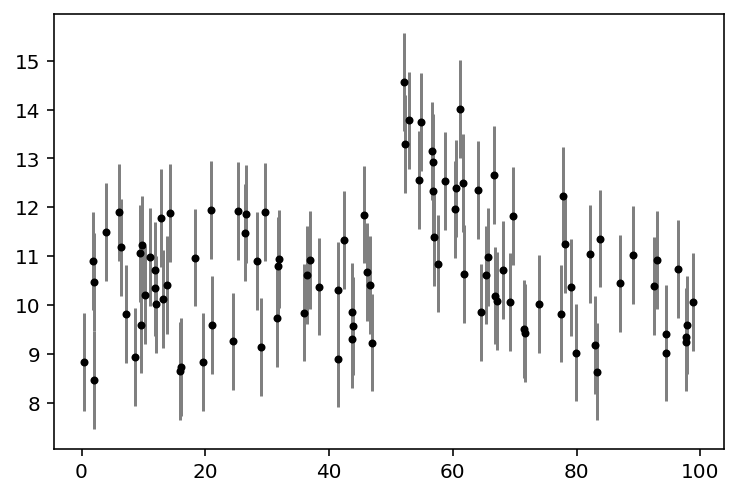

In [3]:
time = data[:,0]
flux = data[:,1]
uncertanties = data[:,2]
plt.errorbar(time, flux, yerr = uncertanties, fmt = '.k', ecolor = 'gray')
plt.show()

In [4]:
def model(time, b, A, a, t_0):
    
    val = []
    
    for t in time:
        if t < t_0:
            val.append(b)
        else:
            val.append(b + A*np.exp(-a*(t-t_0)))
    
    return val

def squared_loss(b, A, a, t_0, time, flux, uncertanties):
            
    return np.sum(((flux-model(time, b, A, a, t_0)) / uncertanties) ** 2, -1)

In [8]:
f_squared = lambda beta: squared_loss(beta[0], beta[1], beta[2], beta[3], time, flux, uncertanties)

beta0 = (10, 5, 0.1, 55)
beta_squared = optimize.fmin(f_squared, beta0)
popt = beta_squared

Optimization terminated successfully.
         Current function value: 97.504517
         Iterations: 106
         Function evaluations: 189


In [9]:
print(popt)

[10.28787715  4.73485302  0.1189057  50.33771247]


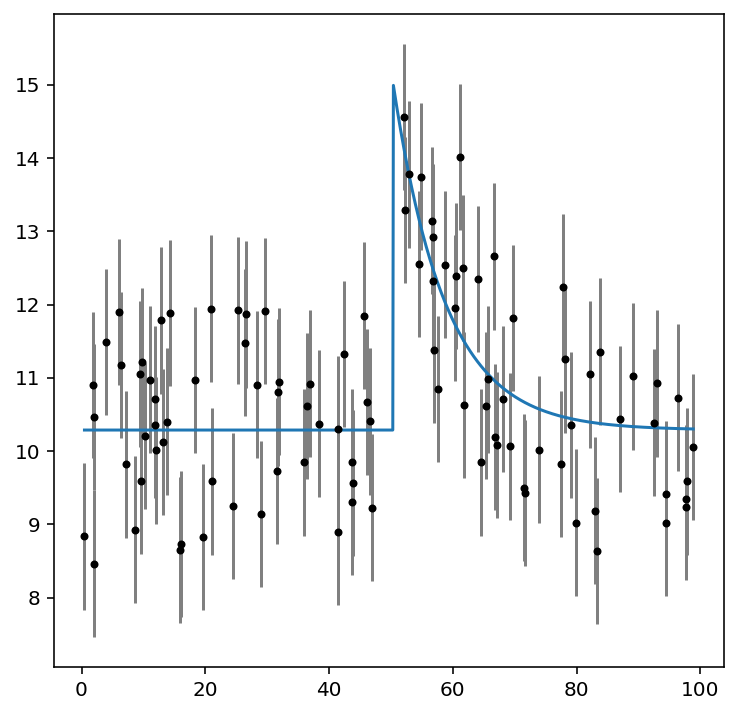

In [10]:
fig = plt.figure(figsize = (6,6))
plt.errorbar(time, flux, yerr = uncertanties, fmt = '.k', ecolor = 'gray')
x_fit = np.linspace(min(time), max(time), 1000)
plt.plot(x_fit, model(x_fit, popt[0], popt[1], popt[2], popt[3]))

In [22]:
def log_likelihood(theta, time, flux, uncertanties):
    
    b, A, a, t_0 = theta
    
    return -0.5 * np.sum((flux - model(time, b, A, a, t_0)) ** 2 / uncertanties + np.log(uncertanties))

def log_prior(theta):
    
    b, A, a, t_0 = theta
    
    if 0.0 < b < 50.0 and 0.0 < A < 50.0 and 0.0 < t_0 < 100.0 and -5.0 < np.log(a) < 5.0:
        return 0.0
    
    return -np.inf

def log_probability(theta, time, flux, uncertanties):
    
    b, A, a, t_0 = theta
    
    lp = log_prior(theta)
    
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, time, flux, uncertanties)

In [23]:
pos = popt + 1e-4 * np.random.randn(32, 4)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args = (time, flux, uncertanties)
)
sampler.run_mcmc(pos, 5000, progress=True);

100%|██████████| 5000/5000 [00:28<00:00, 178.16it/s]


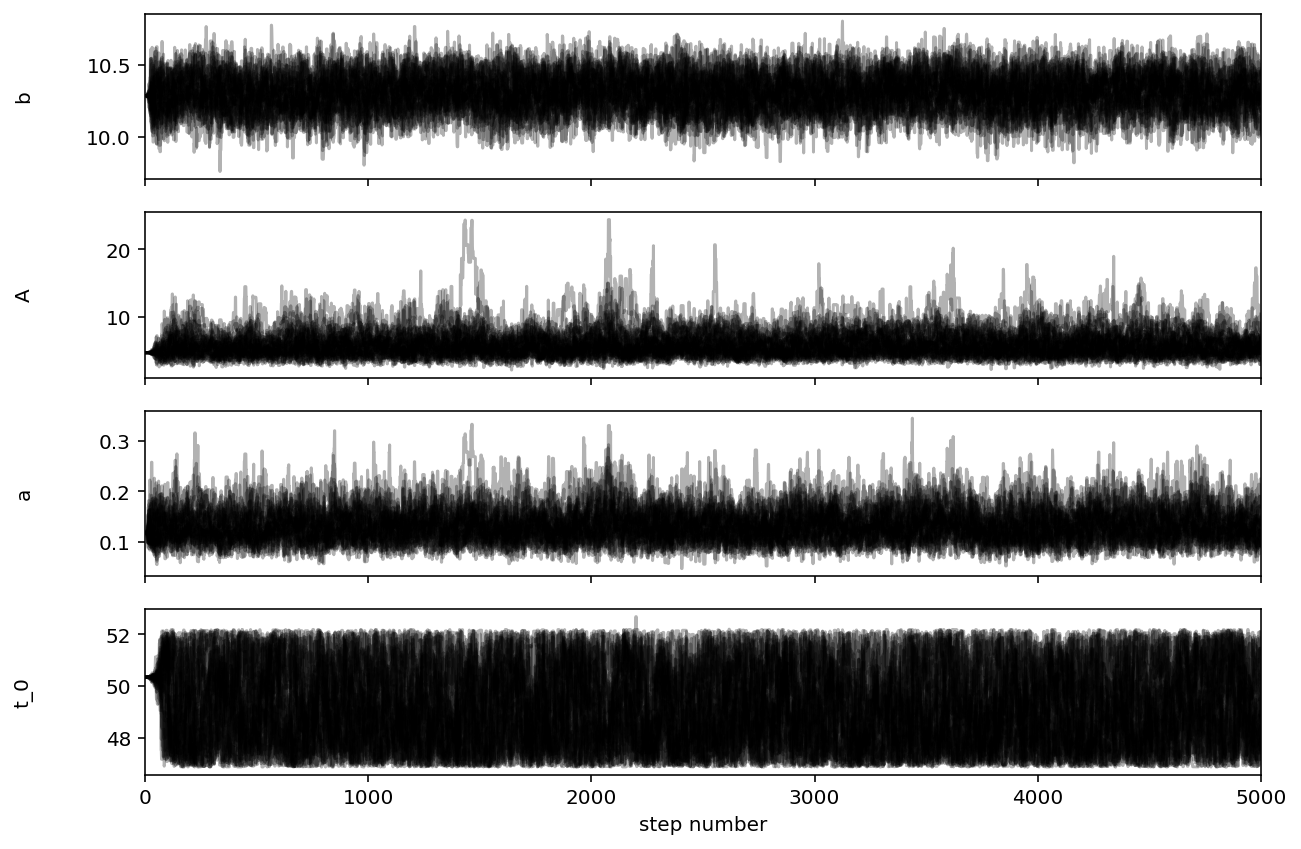

In [24]:
fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["b", "A", "a", "t_0"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [25]:
tau = sampler.get_autocorr_time()
print(tau)

[51.89409437 74.13483391 54.73435885 76.21315345]


In [32]:
flat_samples = sampler.get_chain(discard=100, thin = int(np.mean(tau)), flat=True)
print(flat_samples.shape)

(2432, 4)


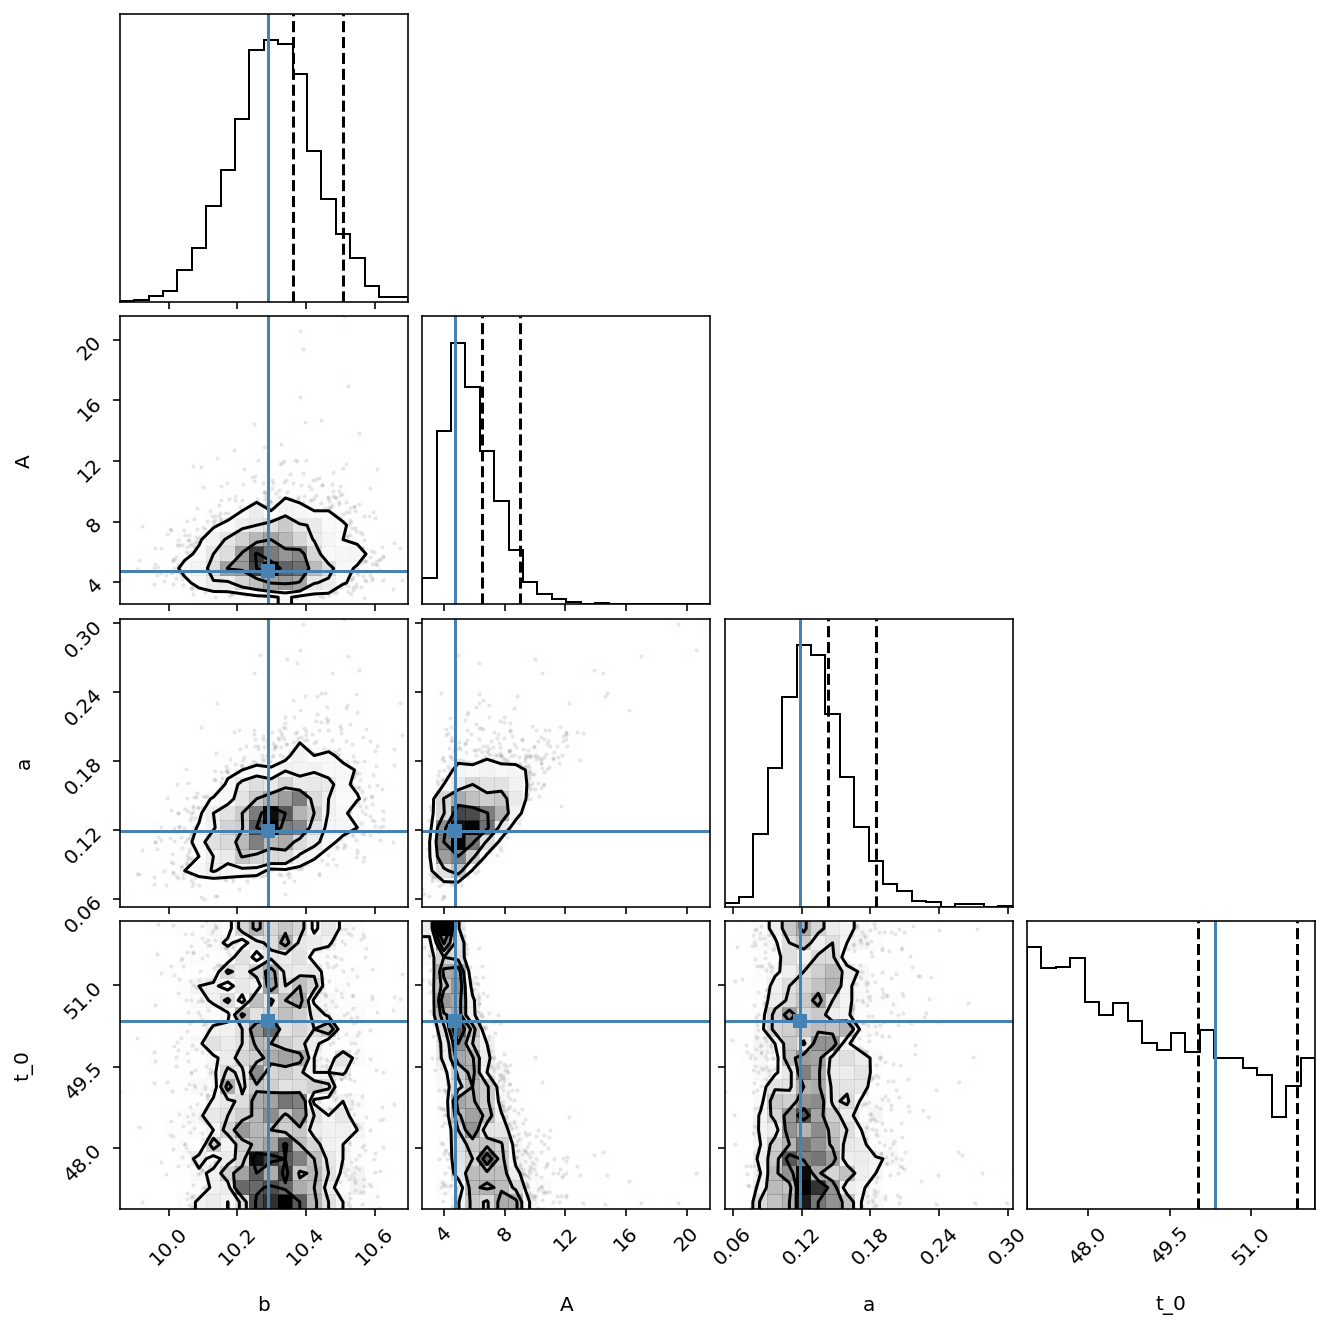

In [40]:
fig = corner.corner(
    flat_samples, labels=labels, truths=[popt[0], popt[1], popt[2], popt[3]], quantiles = [68/100, 95/100]
);

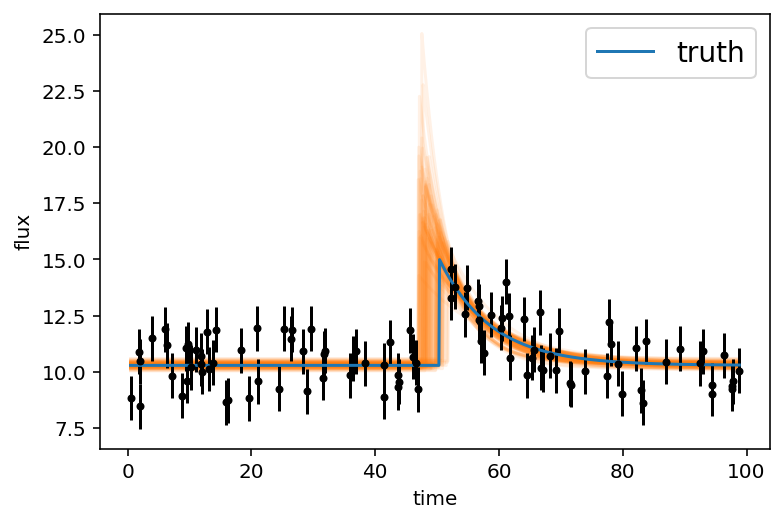

In [42]:
inds = np.random.randint(len(flat_samples), size=100)
for ind in inds:
    sample = flat_samples[ind]
    plt.plot(x_fit, model(x_fit, sample[0], sample[1], sample[2], sample[3]), "C1", alpha=0.1)
    
plt.errorbar(time, flux, yerr=uncertanties, fmt=".k", capsize=0)
plt.plot(x_fit, model(x_fit, popt[0], popt[1], popt[2], popt[3]), label="truth")
plt.legend(fontsize=14)

plt.xlabel("time")
plt.ylabel("flux");

In [47]:
from IPython.display import display, Math

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [5, 50, 95])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>